In [8]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

# Loading data

In [3]:
training_data = datasets.FashionMNIST(
    root="fashion_mnist",
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.FashionMNIST(
    root="fashion_mnist",
    train=False,
    download=True,
    transform=ToTensor(),
)

100%|██████████| 26421880/26421880 [00:00<00:00, 33211440.80it/s]


Extracting fashion_mnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fashion_mnist/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 946740.82it/s]

Extracting fashion_mnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fashion_mnist/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 16702814.27it/s]


Extracting fashion_mnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fashion_mnist/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 15923508.11it/s]

Extracting fashion_mnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fashion_mnist/FashionMNIST/raw



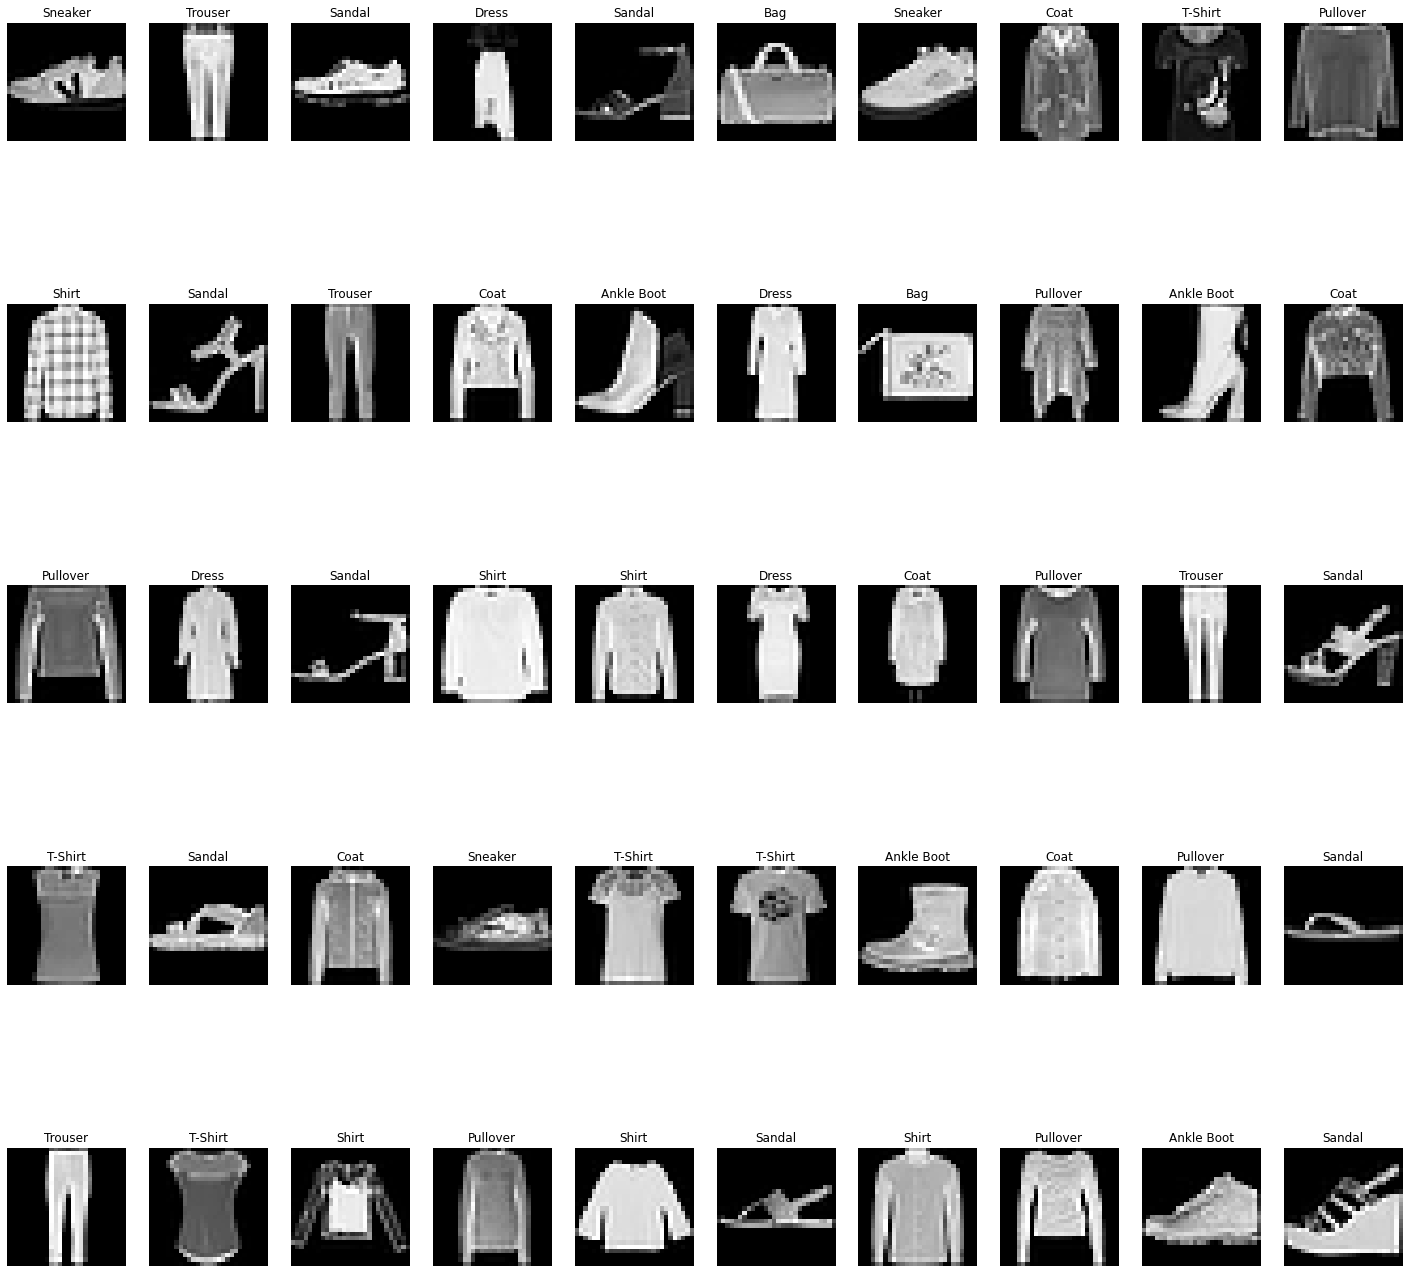

In [11]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(25, 25))
cols, rows = 10, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [12]:
batch_size = 64

train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


# Creating model

We need to set device either cpu or gpu for model to be loded

In [13]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


Definition of the model

In [14]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [15]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

# Training the model

In [17]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")            

In [18]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.302880  [   64/60000]
loss: 2.300796  [ 6464/60000]
loss: 2.282865  [12864/60000]
loss: 2.281938  [19264/60000]
loss: 2.260685  [25664/60000]
loss: 2.226619  [32064/60000]
loss: 2.244519  [38464/60000]
loss: 2.209949  [44864/60000]
loss: 2.208764  [51264/60000]
loss: 2.175508  [57664/60000]
Test Error: 
 Accuracy: 28.0%, Avg loss: 2.172215 

Epoch 2
-------------------------------
loss: 2.181374  [   64/60000]
loss: 2.181568  [ 6464/60000]
loss: 2.129140  [12864/60000]
loss: 2.141899  [19264/60000]
loss: 2.100538  [25664/60000]
loss: 2.036606  [32064/60000]
loss: 2.073395  [38464/60000]
loss: 2.001464  [44864/60000]
loss: 2.005460  [51264/60000]
loss: 1.939485  [57664/60000]
Test Error: 
 Accuracy: 44.4%, Avg loss: 1.934886 

Epoch 3
-------------------------------
loss: 1.966546  [   64/60000]
loss: 1.948986  [ 6464/60000]
loss: 1.841150  [12864/60000]
loss: 1.869408  [19264/60000]
loss: 1.768968  [25664/60000]
loss: 1.715794  [32064/600

# Model predictions

In [19]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')
    pred_figure = plt.figure(figsize=(25, 25))

Predicted: "Ankle boot", Actual: "Ankle boot"


In [50]:
def predict_and_plot(test_data_item):
    model.eval()
    x, y = test_data_item[0], test_data_item[1]
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]

    print(f'Predicted: "{predicted}", Actual: "{actual}"')

    x_img = x.detach().cpu().numpy().squeeze()

    plt.imshow(x_img, cmap="gray")
    plt.show()


Predicted: "Ankle boot", Actual: "Ankle boot"


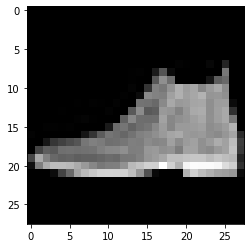

In [51]:
predict_and_plot(test_data[0])

In [57]:
def test_predictions(data):
    model.eval()

    test_cases = len(data)
    passed_cases = 0
    failed_cases = 0

    for data_item in data:
        x, y = data_item[0], data_item[1]
        x = x.to(device)
        pred = model(x)
        predicted, actual = classes[pred[0].argmax(0)], classes[y]

        if predicted == actual:
            passed_cases += 1
        else:
            failed_cases += 1

    passed_percent = passed_cases * 100.0 / test_cases

    print(f'All test cases: {test_cases}\nPassed: {passed_cases}\nFailed: {failed_cases} \nPercentage: {passed_percent}%')

In [58]:
test_predictions(test_data)

All test cases: 10000
Passed: 6376
Failed: 3624 
Percentage: 63.76%
